> For the given dataset lets findout the shapes of nodules

In [1]:
import torch
import cv2
import numpy as np
import pandas as pd
import fastcore.all as fc 

from safetensors.numpy import load_file
from tqdm import tqdm
from voxdet.tfsm.voxt import RandPosCrop

In [2]:
import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline

In [3]:
sids = fc.L(pd.concat([pd.read_csv(i) for i in fc.Path("../studies/only_lidc/folds1/").glob("folds_*.csv")], axis=0)["scans"].unique().tolist())
sids

(#883) ['1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547','1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421','1.3.6.1.4.1.14519.5.2.1.6279.6001.162901839201654862079549658100','1.3.6.1.4.1.14519.5.2.1.6279.6001.483655032093002252444764787700','1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372691745980459537053','1.3.6.1.4.1.14519.5.2.1.6279.6001.655242448149322898770987310561','1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754','1.3.6.1.4.1.14519.5.2.1.6279.6001.302876782304722412779805665588','1.3.6.1.4.1.14519.5.2.1.6279.6001.259123825760999546551970425757','1.3.6.1.4.1.14519.5.2.1.6279.6001.561458563853929400124470098603'...]

In [4]:
sid = f"/qct_cache/lidc_cache_qct/{sids[np.random.randint(len(sids))]}.safetensors"
fc.Path(sid).exists()

True

In [5]:
img = load_file(sid)
img["images"].shape, img["boxes"] #boxes are of the zyxzyx and images are of shape zyx

((239, 225, 322),
 array([[148.5       , 173.74414062, 100.93554688, 153.5       ,
         180.97070312, 107.43945312],
        [138.5       , 160.01367188,  90.81835938, 148.5       ,
         171.57617188, 101.65820312]]))

In [6]:
sid = f"/qct_cache/lidc_cache_qct/{sids[np.random.randint(len(sids))]}.safetensors"
img = load_file(sid)
boxes = torch.Tensor(img["boxes"])
boxes.shape

torch.Size([4, 6])

In [7]:
boxes.shape

torch.Size([4, 6])

In [8]:
abox = torch.empty((0, 6))

In [9]:
abox = torch.cat([abox, boxes])
abox

tensor([[217.5845, 122.7188,  24.9688, 221.7833, 130.2812,  29.0938],
        [119.6123, 198.3438,  57.2812, 135.0079, 221.7188,  75.1562],
        [122.4115, 240.9688,  90.2812, 124.5109, 244.4062,  95.0938],
        [ 83.2227, 223.0938,  74.4688,  88.8211, 230.6562,  84.0938]])

(292, 205, 295)

In [35]:
abox = torch.empty((0, 6))
imgs_shape = []
for sid in tqdm(sids):
    loc = f"/qct_cache/lidc_cache_qct/{sid}.safetensors"
    if not fc.Path(loc).exists(): continue
    img = load_file(f"/qct_cache/lidc_cache_qct/{sid}.safetensors")        
    boxes = torch.Tensor(img["boxes"])
    abox = torch.cat([abox, boxes])
    imgs_shape.append(img["images"].shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 883/883 [00:12<00:00, 71.35it/s]


In [37]:
imgs_shape = np.asarray(imgs_shape)
imgs_shape.shape

(882, 3)

In [11]:
print(abox.shape)
abox

torch.Size([2642, 6])


tensor([[226.6771,  76.3965, 318.0020, 232.2587,  83.6230, 323.0605],
        [209.9321, 111.0840, 314.3887, 215.5138, 120.4785, 324.5059],
        [146.0532,  46.7676,  87.4746, 149.7743,  55.4395,  93.2559],
        ...,
        [148.6186,  20.2734,  73.1172, 154.8241,  32.9297,  86.4766],
        [143.0336,  37.1484,  68.1953, 147.9980,  49.1016,  76.6328],
        [133.7253,  58.2422,  73.1172, 138.6897,  67.3828,  82.2578]])

> store this tensor object as `.pt` file. 

In [12]:
torch.save(abox, "abox_raw.pt")

In [13]:
abox = torch.load("abox_raw.pt")
abox.shape

torch.Size([2642, 6])

## TODO 
- visualize centers in 3d 
- visualize aspect ratios 

In [31]:
z = abox[:, 3] - abox[:, 0]
y = abox[:, 4] - abox[:, 1]
x = abox[:, 5] - abox[:, 2]
zyx = torch.vstack([z, y, x]).T.numpy()
zyx

array([[ 5.58165  ,  7.2265625,  5.0585938],
       [ 5.58165  ,  9.394531 , 10.1171875],
       [ 3.7210999,  8.671875 ,  5.78125  ],
       ...,
       [ 6.205536 , 12.65625  , 13.359375 ],
       [ 4.9644165, 11.953125 ,  8.4375   ],
       [ 4.964432 ,  9.140625 ,  9.140625 ]], dtype=float32)

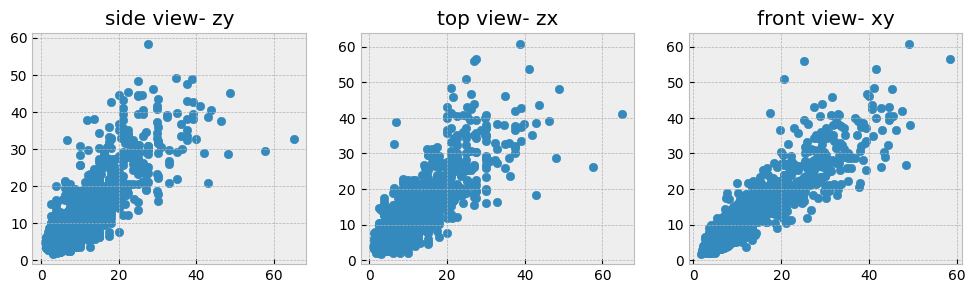

In [33]:
fig, ax = plt.subplots(figsize=(12, 3), nrows=1, ncols=3)
ax.flat[0].scatter(zyx[:, 0], zyx[:, 1])
ax.flat[0].set_title("side view- zy")
ax.flat[1].scatter(zyx[:, 0], zyx[:, 2])
ax.flat[1].set_title("top view- zx")
ax.flat[2].scatter(zyx[:, 1], zyx[:, 2])
ax.flat[2].set_title("front view- xy")
plt.show()

## hwd of a nodule 

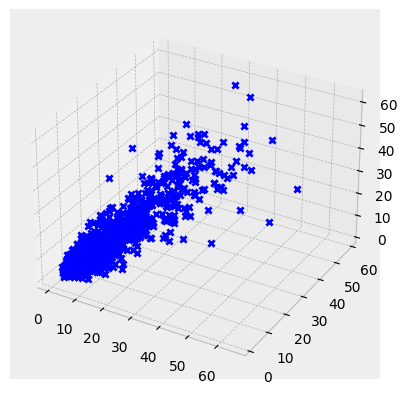

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for point in zyx:
    z, y, x = point
    ax.scatter(z, y, x, c='b', marker='x')

plt.show()

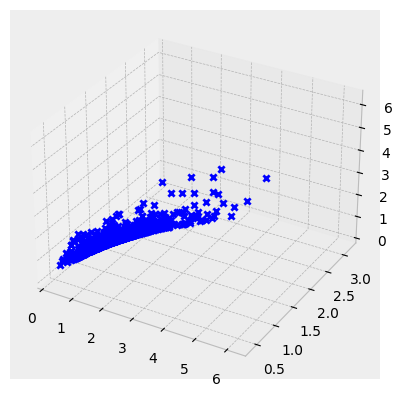

In [46]:
hw = zyx[:, 1]/zyx[:, 2]
hd = zyx[:, 1]/zyx[:, 0]
wd = zyx[:, 2]/zyx[:, 0]

ar = np.vstack([hd, hw, wd]).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for point in ar:
    z, y, x = point
    ax.scatter(z, y, x, c='b', marker='x')

plt.show()

In [54]:
np.median(ar, axis=0), np.mean(ar, axis=0), np.max(ar, axis=0), np.min(ar, axis=0)

(array([1.1183788, 1.       , 1.1194583], dtype=float32),
 array([1.2351344, 1.029858 , 1.2345966], dtype=float32),
 array([6.153127 , 3.1666667, 6.1875   ], dtype=float32),
 array([0.28079343, 0.4057971 , 0.20742187], dtype=float32))

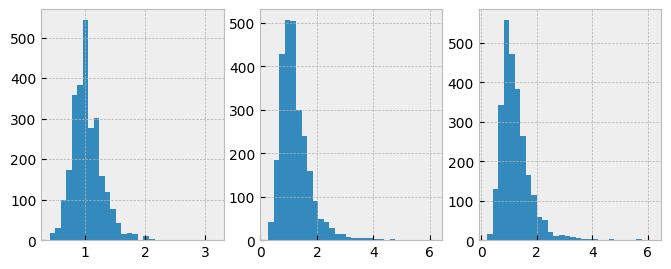

In [47]:
fig, ax = plt.subplots(figsize=(8, 3), nrows=1, ncols=3)
ax.flat[0].hist(hw, bins=30)
ax.flat[1].hist(hd, bins=30)
ax.flat[2].hist(wd, bins=30)
plt.show()

> why is hd and wd have wired aspect ratios? is this because of resampling? 

Usually we can expect this to happen in axial direction as nodule size is large and happens to be seen in only few slices. 
20x20 nodule present in 3 slices will have aspect ratio of ~7 in hd and wd directions.

## image shapes 

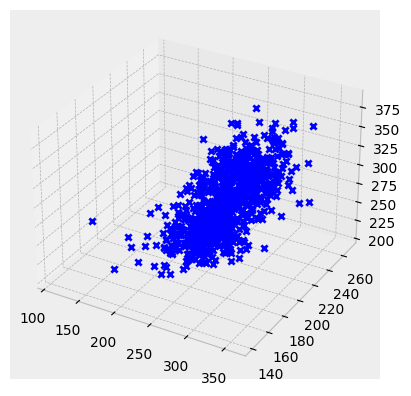

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for point in imgs_shape:
    z, y, x = point
    ax.scatter(z, y, x, c='b', marker='x')

plt.show()

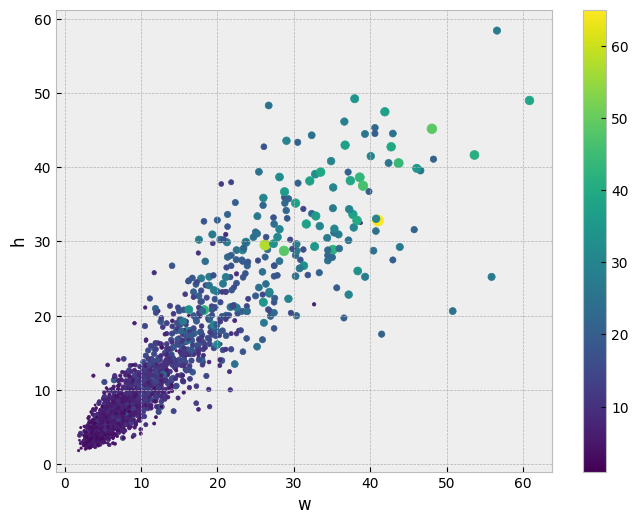

In [52]:
#fig, ax = plt.subplots(figsize=(8, 3), nrows=1, ncols=1)
plt.figure(figsize=(8, 6))
sc = plt.scatter(zyx[:, 2], zyx[:, 1], s=zyx[:, 0], c=zyx[:, 0])
plt.xlabel("w")
plt.ylabel("h")
plt.colorbar(sc)
plt.show()

> Post rand pos crop we can see that the objects shapes are varied when compared to 02b notebook. and this too is happening for a very few objects. should we write a transform to check for weird aspect ratios and make sure they not happen?


### max & min aspect ratio on raw scans resampled:
array([6.153127 , 3.1666667, 6.1875   ], dtype=float32),
array([0.28079343, 0.4057971 , 0.20742187], dtype=float32))

### max & min aspect ratio on using RandPosCrop (96, 192, 192)
array([ 706.9238, 3420.    ,  530.1929], dtype=float32),
array([0.0703125 , 0.07166667, 0.00044714], dtype=float32))


we checked and around 3% of the data has weired shapes. this comes after running the algo 5 times on each CT scan.

> Max and min in volume 

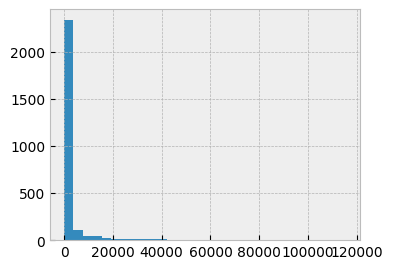

In [59]:
vol = zyx.prod(axis=1)
plt.figure(figsize=(4, 3))
plt.hist(vol, bins=30)
plt.show()

In [61]:
vol.min(), vol.max(), vol.mean(), np.median(vol)

(9.961956, 115519.89, 2559.0964, 284.34384)

In [62]:
ar[vol == 115519.89]

array([[1.264113  , 0.80487806, 1.5705645 ]], dtype=float32)

In [75]:
zyx[(zyx>30).sum(axis=1).nonzero()[0]].shape

(125, 3)

In [76]:
vol[vol<27].shape

(37,)